In [22]:
import re
import nltk
#nltk.download('punkt')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [23]:
nltk.download("stopwords")

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Data Source 
The data has been obtained by the merger of two resume datasets in kaggle, containing resumes of multiple categories.

In [24]:
data = pd.read_excel('C://Users//Ambarish Deb//Downloads//mba resume data.xlsx')
data.head()

,category,rawtext
0,Data Science,Expertise â Data and Quantitative Analysis â...
1,Data Science,Expertise â Data and Quantitative Analysis â...
2,Data Science,Expertise â Data and Quantitative Analysis â...
3,Data Science,Expertise â Data and Quantitative Analysis â...
4,HR,TECHNICAL SKILLS â¢ Typewriting â¢ TORA â¢ ...


In [25]:
data['category']=data['category'].astype(str)
data['category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2184 entries, 0 to 2183
Series name: category
Non-Null Count  Dtype 
--------------  ----- 
2184 non-null   object
dtypes: object(1)
memory usage: 17.2+ KB


### Data Cleaning

In [26]:
data['category'].value_counts()

HR                           173
BUSINESS-DEVELOPMENT         119
INFORMATION-TECHNOLOGY       119
CONSULTANT                   115
ADVOCATE                     115
SALES                        115
DESIGNER                     106
DIGITAL-MEDIA                 95
Java Developer                90
Mechanical Engineer           72
Testing                       70
ETL Developer                 64
Operations Manager            60
Arts                          60
DevOps Engineer               58
Sales                         56
Business Analyst              56
Python Developer              56
Blockchain                    56
Web Designing                 54
Network Security Engineer     45
Data Science                  44
Database                      42
Hadoop                        42
PMO                           40
Automation Testing            40
Civil Engineer                40
Health and fitness            40
SAP Developer                 36
Electrical Engineering        30
DotNet Dev

The titles are quire varied. They can be grouped into categories for ease.

In [27]:
def cleantitles(x):
    if "hr" in str(x).lower() or "recruiter" in x.lower():
        x="HR"
    elif "finance" in str(x).lower() or "account" in str(x).lower() or "banking" in str(x).lower():
        x="Finance"
    elif "manager" in str(x).lower() or "pmo" in str(x).lower() or "incharge" in str(x).lower() or "superintendent" in str(x).lower():
        x="Management"
    elif "marketing" in str(x).lower():
        x="Marketing"
    elif "business-" in str(x).lower() or "business development" in str(x).lower() or "sales" in str(x).lower():
        x="Business Development"
    elif "database" in str(x).lower():
        x="Database"
    elif "python" in str(x).lower() or "java"in str(x).lower():
        x="Software Development"
    elif "web"in str(x).lower():
        x="Web Development"
    elif "security" in str(x).lower():
        x="Cybersecurity"
    elif "sap" in str(x).lower():
        x="ERP"
    elif "design" in str(x).lower():
        x="Graphic Design"
    elif "digital" in str(x).lower():
        x="Digital Media Management"
    elif "test" in str(x).lower():
        x="QA"
    elif "customer" in str(x).lower() or "bpo" in str(x).lower():
        x="Customer Support"
    elif "devops"  in str(x).lower():
        x="DevOps"
    elif "hadoop" in str(x).lower() or "etl" in str(x).lower() or "science"  in str(x).lower():
        x="Data Science and engineering"
    elif "analyst"  in str(x).lower():
        x="Business Analytics"
    elif "consultant" in str(x).lower():
        x="Consultant"
    else:
        x="Misc"
    
    return x
data['category']=data['category'].apply(cleantitles)

In [28]:
data['category'].value_counts()

Misc                            585
Business Development            291
HR                              173
Data Science and engineering    150
Software Development            146
Consultant                      115
QA                              110
Graphic Design                  106
Management                      100
Digital Media Management         95
DevOps                           58
Business Analytics               56
Web Development                  54
Cybersecurity                    45
Database                         43
ERP                              36
Customer Support                 21
Name: category, dtype: int64

Dropping "misc" as those categories aren't needed by globalcert

In [29]:
data = data.drop(data[data['category'] == "Misc"].index)
data['category'].value_counts()

Business Development            291
HR                              173
Data Science and engineering    150
Software Development            146
Consultant                      115
QA                              110
Graphic Design                  106
Management                      100
Digital Media Management         95
DevOps                           58
Business Analytics               56
Web Development                  54
Cybersecurity                    45
Database                         43
ERP                              36
Customer Support                 21
Name: category, dtype: int64

### EDA, preprocessing

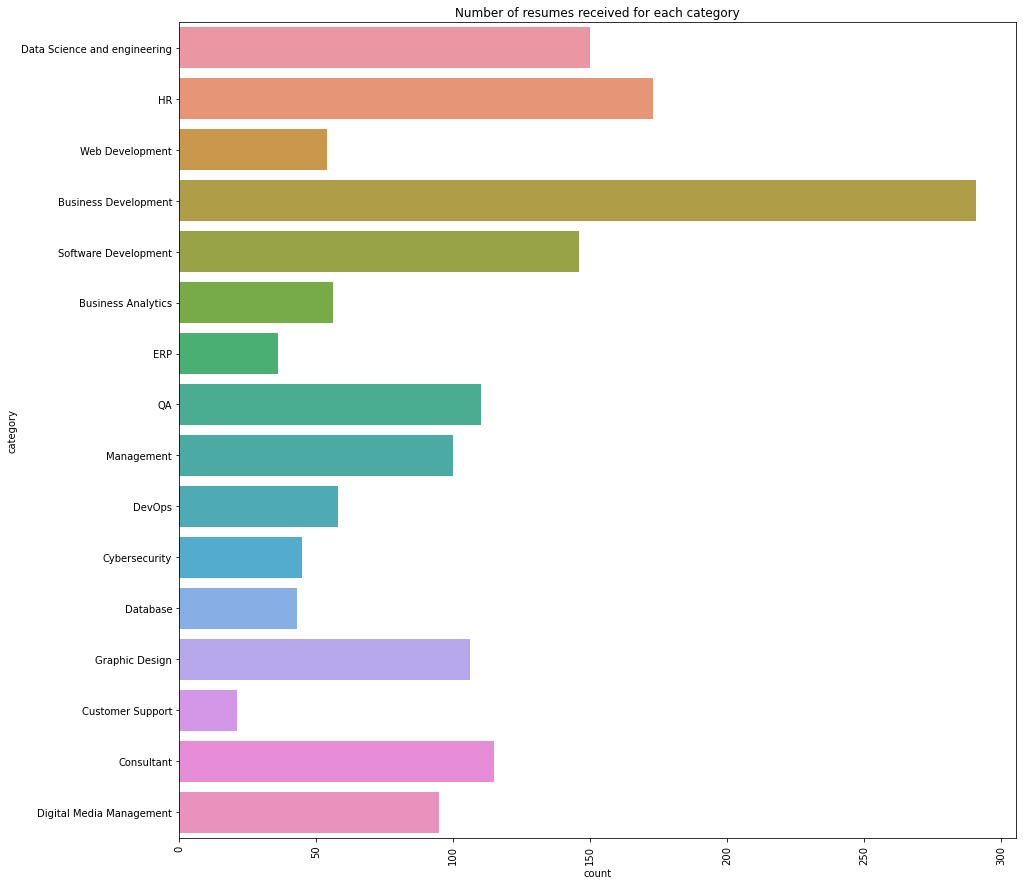

In [40]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="category", data=data)
plt.title("Number of resumes received for each category")
plt.show()

In [31]:
targetCounts = data['category'].value_counts().reset_index()['category']
targetLabels  = data['category'].value_counts().reset_index()['index']

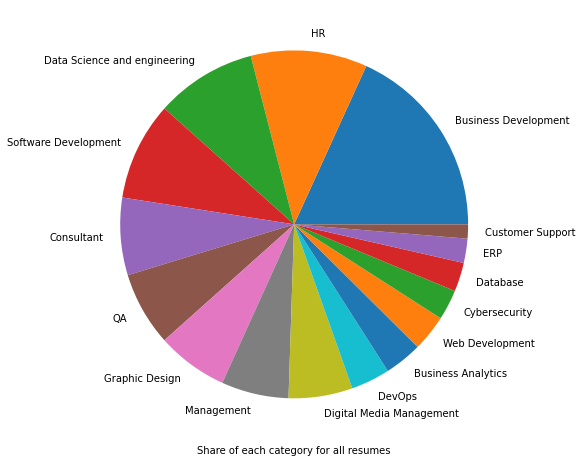

In [32]:
plt.figure(figsize=(8,8))
plt.pie(targetCounts, labels=targetLabels)
plt.title("Share of each category for all resumes")
plt.show()

#### Cleaning resume text
Resume text contains not only information about the candidate's background but a lot if unnecessary material as well, like extra symbols, hashtags, whitespaces as well as other aberrations which may be generated due to conversion of files to text format. They need to be removed. Here line by line, each such category is being taken care of.

The data being saved in csv shall be used for resume parsing

In [33]:
def cleanResume(txt):
    txt = txt.lower()
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)
    txt = re.sub('RT|cc', ' ', txt)
    txt = re.sub('#\S+', '', txt) 
    txt = re.sub('@\S+', '  ', txt) 
    txt = re.sub('\s+', ' ', txt) 
    return txt
data['cleaned data'] = data['rawtext'].apply(lambda x: cleanResume(x))
del  data['rawtext']
data
data.to_csv("Cleaned resume data.csv")

#### Tokenization

Tokenization breaks the raw text into words, sentences called tokens. These tokens help in understanding the context or developing the model for the NLP. The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words.

In [34]:
def tokenise(txt):
    txt = nltk.tokenize.word_tokenize(txt)
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
    return ' '.join(txt)
data['cleaned data'] = data['cleaned data'].apply(lambda w: tokenise(w))
data

,category,cleaned data
0,Data Science and engineering,expertise data quantitative analysis decision ...
1,Data Science and engineering,expertise data quantitative analysis decision ...
2,Data Science and engineering,expertise data quantitative analysis decision ...
3,Data Science and engineering,expertise data quantitative analysis decision ...
4,HR,technical skills typewriting tora spsseducatio...
...,...,...
2178,Digital Media Management,digital advertising consultant experience digi...
2179,Digital Media Management,digital communications specialist summary digi...
2180,Digital Media Management,digital marketing ount manager experience digi...
2181,Digital Media Management,digital marketing manager career focus digital...


#### Q - What are the most common words?

In [35]:
import string
from nltk.corpus import stopwords
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = data['cleaned data'].values
cleanedSentences = ""
for records in Sentences:
    cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

In [36]:
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('company', 8080), ('management', 6028), ('sales', 4784), ('project', 4755), ('business', 4747), ('state', 4583), ('exprience', 4121), ('city', 4048), ('team', 3947), ('months', 3637), ('data', 3578), ('name', 3426), ('customer', 3255), ('development', 3202), ('description', 3117), ('details', 3095), ('skills', 2933), ('new', 2809), ('client', 2556), ('marketing', 2369), ('system', 2307), ('training', 2204), ('service', 2196), ('design', 2069), ('experience', 2058), ('testing', 2056), ('manager', 2052), ('services', 2011), ('work', 1981), ('process', 1975), ('operations', 1906), ('using', 1886), ('test', 1867), ('database', 1856), ('year', 1814), ('support', 1790), ('reports', 1772), ('education', 1759), ('information', 1704), ('customers', 1648), ('software', 1629), ('university', 1621), ('developed', 1528), ('january', 1515), ('clients', 1509), ('office', 1506), ('sql', 1493), ('various', 1471), ('requirements', 1458), ('product', 1420)]


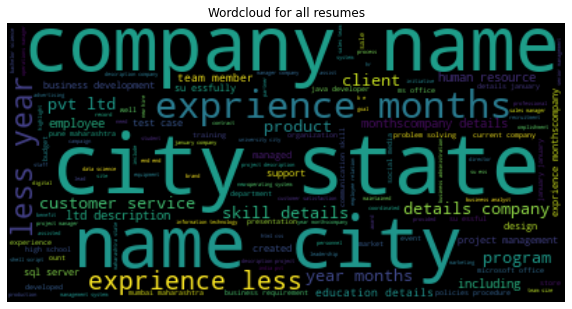

In [39]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for all resumes")
plt.show()

In [17]:
categories = np.sort(data['category'].unique())
categories

array(['Business Analytics', 'Business Development', 'Consultant',
       'Customer Support', 'Cybersecurity',
       'Data Science and engineering', 'Database', 'DevOps',
       'Digital Media Management', 'ERP', 'Graphic Design', 'HR',
       'Legal Counsel', 'Management', 'QA', 'Software Development',
       'Web Development'], dtype=object)

In [18]:
pdcategories = [data[data['category'] == category].loc[:, ['cleaned data', 'category']] for category in categories]
pdcategories

[                                          cleaned data            category
 141  education details computer science mumbai maha...  Business Analytics
 142  technical skills application servers iis jboss...  Business Analytics
 143  key skills requirement gathering requirement a...  Business Analytics
 144  skills area exposure modeling tool bizagi ms v...  Business Analytics
 145  technological skills knowledge computers windo...  Business Analytics
 146  education details february february tybcom com...  Business Analytics
 147  key skills requirement gathering requirement a...  Business Analytics
 148  skills area exposure modeling tool bizagi ms v...  Business Analytics
 149  technological skills knowledge computers windo...  Business Analytics
 150  education details february february tybcom com...  Business Analytics
 151  key skills requirement gathering requirement a...  Business Analytics
 152  skills area exposure modeling tool bizagi ms v...  Business Analytics
 153  techno

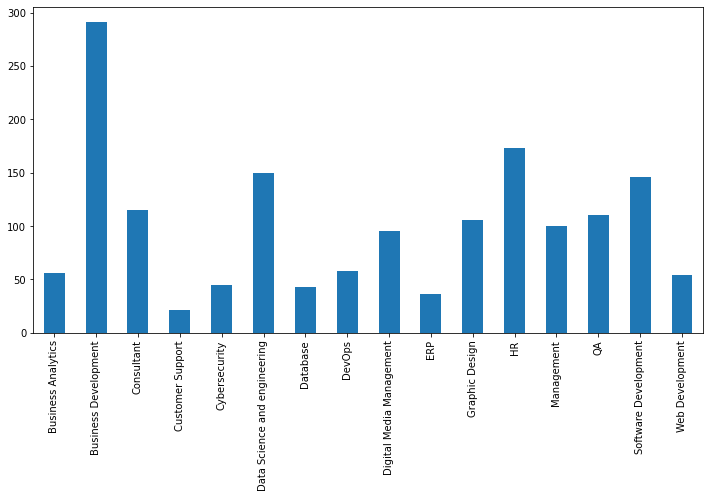

In [18]:
data['category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title("Resumes by count of category")
plt.show()

Certain categories like customer support and ERP are much less in number compared to others, as can be inferred from the above chart and the pie chart.
Checking if imbalance can be reduced by removing duplicates

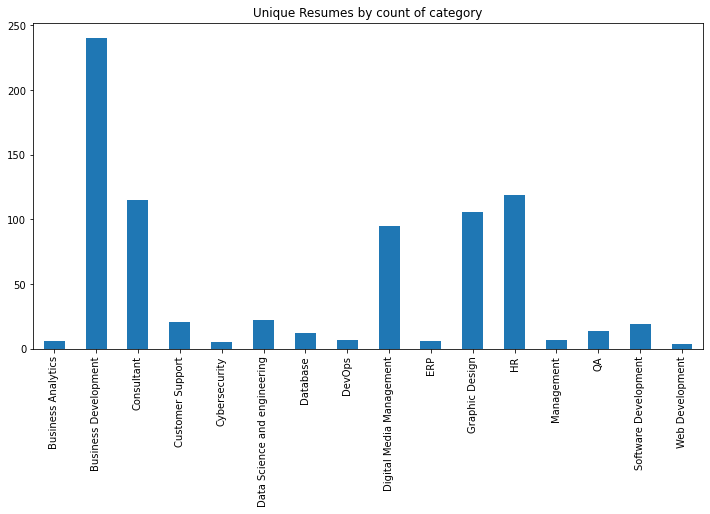

In [41]:
data.drop_duplicates(subset=['cleaned data'])['category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title("Unique Resumes by count of category")
plt.show()

The imbalance increased on removing duplicate points. 
Redoing the visualizations with unique data points

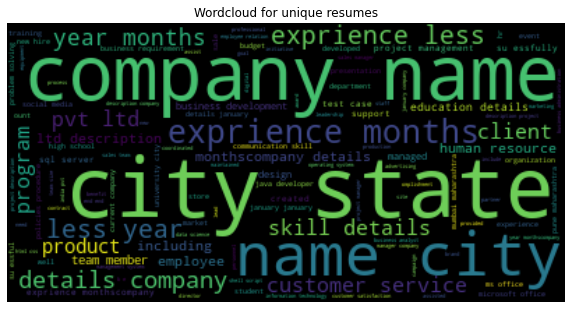

In [42]:
uniquedata=data.drop_duplicates(subset=['cleaned data'])
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = data['cleaned data'].values
cleanedSentences = ""
for records in Sentences:
    cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for unique resumes')
plt.show()

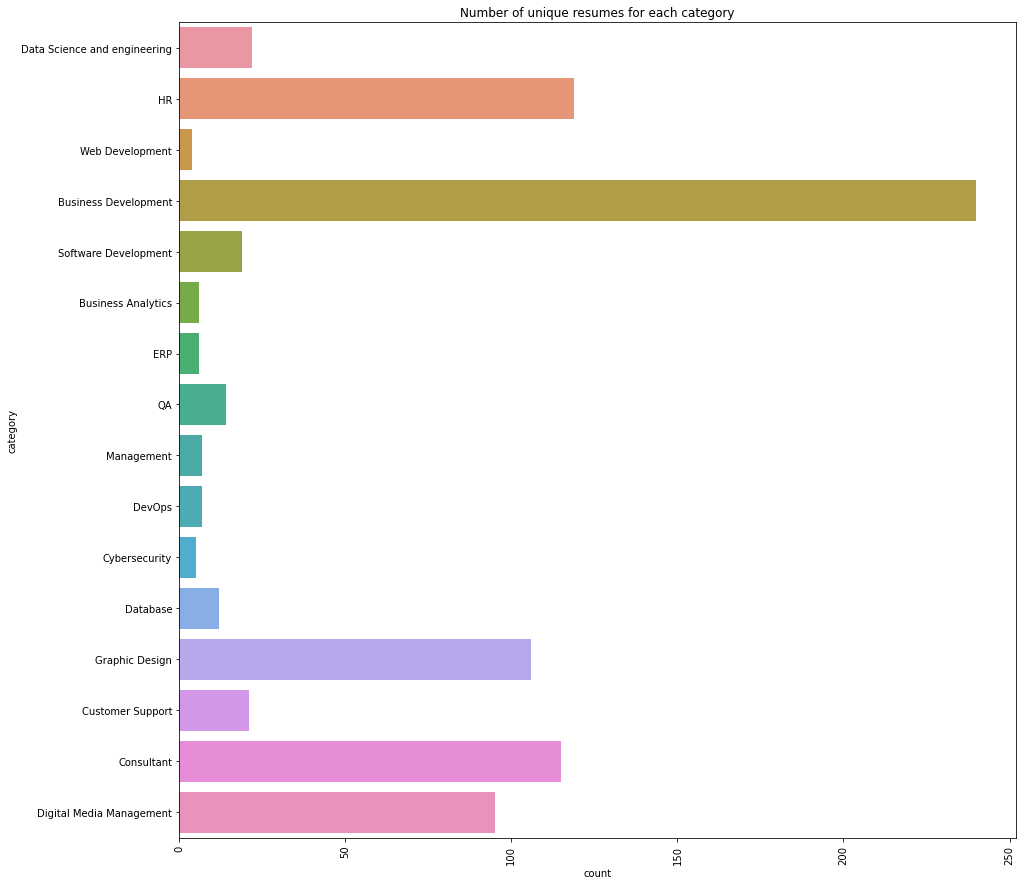

In [43]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="category", data=uniquedata)
plt.title("Number of unique resumes for each category")
plt.show()

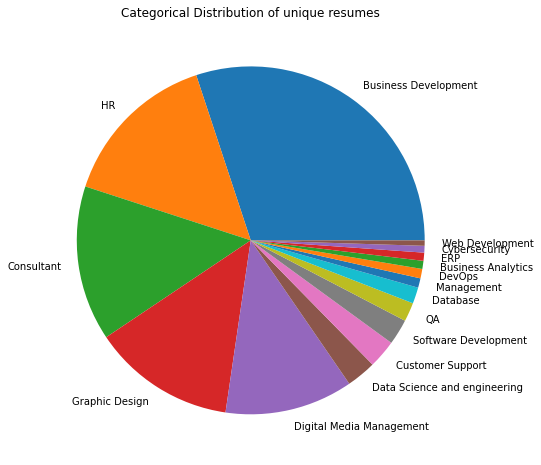

In [45]:
targetCounts = uniquedata['category'].value_counts().reset_index()['category']
targetLabels  = uniquedata['category'].value_counts().reset_index()['index']
plt.figure(figsize=(8,8))
plt.pie(targetCounts, labels=targetLabels)
plt.title("Categorical Distribution of unique resumes")
plt.show()

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data

,category,cleaned data
0,5,expertise data quantitative analysis decision ...
1,5,expertise data quantitative analysis decision ...
2,5,expertise data quantitative analysis decision ...
3,5,expertise data quantitative analysis decision ...
4,11,technical skills typewriting tora spsseducatio...
...,...,...
2178,8,digital advertising consultant experience digi...
2179,8,digital communications specialist summary digi...
2180,8,digital marketing ount manager experience digi...
2181,8,digital marketing manager career focus digital...


#### Vectorization
he process of converting words into numbers for the purpose of finding word similarities is called Vectorization.
Here words are converted into a numerical format for proper mathematical analysis.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

Text = data['cleaned data'].values
Target = data['category'].values

X = data['cleaned data']
Y = data['category']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=42, test_size=0.2, shuffle=True, stratify=Y)

word_vectorizer = TfidfVectorizer (sublinear_tf=True, stop_words='english')
word_vectorizer.fit(X_train.values.ravel())
X_train=word_vectorizer.transform(X_train.values.ravel()).toarray()
X_test=word_vectorizer.transform(X_test.values.ravel()).toarray()

#### SMOTE
As we saw earlier, the dataset was quite unbalanced. Using it as it is for analysis will cause problems as it may become unable to predict minority classes. Hence we use SMOTE to over sample the minority classes while inducing small aberrations in them.

In [28]:
from imblearn.over_sampling import SMOTE
print("before SMOTE: ", X_train.shape, Y_train.shape)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
print("after SMOTE:", X_train.shape, Y_train.shape)


before SMOTE:  (1390, 19736) (1390,)
after SMOTE: (3961, 19736) (3961,)


### Modeling, Metrics

In [30]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)
print('Accuracy on training set: {:.2f}'.format(clf.score(X_train, Y_train)))
print('Accuracy on test set:     {:.2f}'.format(clf.score(X_test, Y_test)))

Accuracy of KNeighbors Classifier on training set: 0.95
Accuracy of KNeighbors Classifier on test set:     0.78


In [32]:
from  sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.26      0.41        58
           2       0.48      0.43      0.45        23
           3       0.19      1.00      0.32         4
           4       1.00      1.00      1.00         9
           5       1.00      0.93      0.97        30
           6       0.90      1.00      0.95         9
           7       0.92      1.00      0.96        12
           8       0.53      0.84      0.65        19
           9       0.78      1.00      0.88         7
          10       0.74      0.81      0.77        21
          11       0.97      0.91      0.94        35
          12       0.44      0.68      0.54        28
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        29
          16       1.00      1.00      1.00        11

    accuracy              

### saving model

In [35]:
import pickle
pickle.dump(clf,open("nlpmodel.sav", 'wb'))

ERROR: Could not find a version that satisfies the requirement tika (from versions: none)
ERROR: No matching distribution found for tika
